# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**
Данные геологоразведки трёх регионов находятся в файлах: 
- */datasets/geo_data_0.csv*
- */datasets/geo_data_1.csv*
- */datasets/geo_data_2.csv*
Каждый набор данных содержит:
- *id* — уникальный идентификатор скважины;
- *f0, f1, f2* — три признака точек (неважно, что они означают, но сами признаки значимы);
- *product* — объём запасов в скважине (тыс. баррелей).

**Условия задачи**:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import ydata_profiling
import numpy as np
#подготовка данных
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
#модель линейной регрессии
from sklearn.linear_model import LinearRegression
#метрики модели
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [2]:
df_0 = pd.read_csv('/datasets/geo_data_0.csv')
df_1 = pd.read_csv('/datasets/geo_data_1.csv')
df_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
ydata_profiling.ProfileReport(df_0)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
ydata_profiling.ProfileReport(df_1)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
ydata_profiling.ProfileReport(df_2)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Все наборы данных однотипны и не содержат пропуски, значения признаков стандартизированы. Наблюдается корреляция между f2 и product, при этом в первом и третьем регионах она менее значима, чем во втором. Можно отделять целевой признак и делить на выборки. Также предлагается избавиться от идентификатора измерения, который в данном случае не будет играть большого значения.

In [7]:
STATE = 123
def data_prep(df):
    #отделение признаков и целевого признака
    features = df[['f0', 'f1', 'f2']]
    target = df['product']
    #деление на выборки
    train_features, valid_features, train_target, valid_target = train_test_split(features, target, test_size = 0.25, random_state=STATE)
    
    return train_features, valid_features, train_target, valid_target


In [8]:
train_features, valid_features, train_target, valid_target = data_prep(df_0)
print(train_features.shape, valid_features.shape, train_target.shape, valid_target.shape)

(75000, 3) (25000, 3) (75000,) (25000,)


**Вывод:** данные загружены, написана и протестирована функция, которая отделяет целевой признак и делит датасет на обучающую и валидационную выборки.

## Обучение и проверка модели

In [9]:
def lin_reg_res(train_features, valid_features, train_target, valid_target):
    lr = LinearRegression()
    lr.fit(train_features, train_target)
    predictions = lr.predict(valid_features)
    rmse = mean_squared_error(valid_target, predictions, squared=False)
    print(f"Средний предсказанный объем сырья на одну скважину: {predictions.mean()}\nRMSE={rmse}")
    
    return predictions, rmse

In [10]:
results = []
counter = 1
for df in [df_0, df_1, df_2]:
    train_features, valid_features, train_target, valid_target = data_prep(df)
    print(f'Показатели региона {counter}')
    predictions, rmse = lin_reg_res(train_features, valid_features, train_target, valid_target)
    print('--------------\n')
    predictions = pd.Series(predictions, index = valid_target.index)
    results.append({'predictions_prod': predictions, 'valid_target': valid_target, 'pred_prod_mean': predictions.mean(), 'rmse': rmse})
    counter += 1
results

Показатели региона 1
Средний предсказанный объем сырья на одну скважину: 92.54936189116306
RMSE=37.64786282376177
--------------

Показатели региона 2
Средний предсказанный объем сырья на одну скважину: 69.28001860653976
RMSE=0.8954139804944313
--------------

Показатели региона 3
Средний предсказанный объем сырья на одну скважину: 95.09859933591373
RMSE=40.12803006598514
--------------



[{'predictions_prod': 42083    123.284256
  71825     75.838240
  99535     55.526760
  47879     86.673045
  36734    109.909327
              ...    
  56405     89.708779
  50954     55.672078
  99121    139.042911
  4170      96.867927
  18144     54.714331
  Length: 25000, dtype: float64,
  'valid_target': 42083    145.825972
  71825    134.020212
  99535     88.905826
  47879     19.508226
  36734    108.713468
              ...    
  56405     80.100250
  50954     47.345664
  99121    176.382705
  4170     140.334745
  18144    117.324049
  Name: product, Length: 25000, dtype: float64,
  'pred_prod_mean': 92.54936189116306,
  'rmse': 37.64786282376177},
 {'predictions_prod': 42083     56.056314
  71825     81.589811
  99535     54.461926
  47879    108.660979
  36734     54.479416
              ...    
  56405     28.805734
  50954    110.025164
  99121      3.278982
  4170      53.705839
  18144    135.021879
  Length: 25000, dtype: float64,
  'valid_target': 42083     57.0856

**Вывод:** 
- написана функция, возвращающая среднеквадратическую ошибку линейной регрессии и результаты предсказаний
- все датафреймы разделены на обучающую и валидационную выборки 
- с помощью линейной регрессии предсказаны значения валидационной выборки и найдена среднеквадратическая ошибка модели во всех регионах
- наиболее точные предсказания модель дала во втором регионе, при этом средний предсказанный объем сырья на одну скважину на 23-26 единиц меньше, чем в первом и третьем регионе. Однако если принимать во внимание, что модель в среднем может ошибаться на +-37-40 единиц продукта в первом и третьем регионе, то потенциальная прибыль в этих регионах может быть или значительно выше, или существенно ниже.

## Подготовка к расчёту прибыли

In [11]:
COST_PRODUCTION = 10_000_000_000
PRODUCTION_VALUE = 450_000
NUM_WELLS = 500
NUM_BEST_WELLS = 200
#объем добычи на одну скважину, чтобы выйти в ноль
no_loss = COST_PRODUCTION / PRODUCTION_VALUE / NUM_BEST_WELLS
print('Безубыточная добыча на одну скважину: ', no_loss)

Безубыточная добыча на одну скважину:  111.11111111111111


Запас 200 отобранных моделью скважин должен быть чуть больше 111 баррелей. 

## Расчёт прибыли и рисков 

In [12]:
def profit(predictions, valid_target):
    
    best_indices = predictions.sort_values(ascending=False).index[:NUM_BEST_WELLS]
    profit = sum(valid_target[best_indices]) * PRODUCTION_VALUE - COST_PRODUCTION
    
    return profit

In [13]:
profit(results[0]['predictions_prod'], results[0]['valid_target'])

3534670917.2613792

In [14]:
profit(results[1]['predictions_prod'], results[1]['valid_target'])

2415086696.681551

In [15]:
profit(results[2]['predictions_prod'], results[2]['valid_target'])

2370343863.021372

Из предсказанных значений наиболее прибыльным первый регион, однако среднеквадратическая ошибка модели в этом регионе значительно выше, чем во втором. Прибыль во втором регионе ниже, но при этом предсказания более точные.

In [16]:
def losses_proba(predictions, valid_target):
    state = np.random.RandomState(123)
    results = []
    count = 0
    for i in range(1000):
        sample = pd.Series(predictions).sample(n=NUM_WELLS, replace=False, random_state = state)
        top_200_profit = profit(sample, valid_target[sample.index])
        results.append(top_200_profit)
        if top_200_profit < 0:
            count += 1
    loss_probability = count / 1000
    
    return results, loss_probability   

In [17]:
results_0, loss_probability_0 = losses_proba(results[0]['predictions_prod'], results[0]['valid_target'])
print(f"Вероятность убытков: {loss_probability_0:.1%}")

Вероятность убытков: 2.5%


In [18]:
results_1, loss_probability_1 = losses_proba(results[1]['predictions_prod'], results[1]['valid_target'])
print(f"Вероятность убытков: {loss_probability_1:.1%}")

Вероятность убытков: 1.1%


In [19]:
results_2, loss_probability_2 = losses_proba(results[2]['predictions_prod'], results[2]['valid_target'])
print(f"Вероятность убытков: {loss_probability_2:.1%}")

Вероятность убытков: 9.3%


Вероятность убытков ниже 2,5% только во втором регионе.

In [20]:
pd.Series(results_0).mean()

485558252.5586561

In [21]:
pd.Series(results_1).mean()

455943906.6581479

In [22]:
pd.Series(results_2).mean()

338388653.5504326

In [23]:
1 - pd.Series(results_1).mean() / pd.Series(results_0).mean()

0.0609903049622883

По итогам бутстрепинга самое высокое среднее значение оказалось в первом регионе. Показатели второго региона на 6,1% ниже.

<AxesSubplot:>

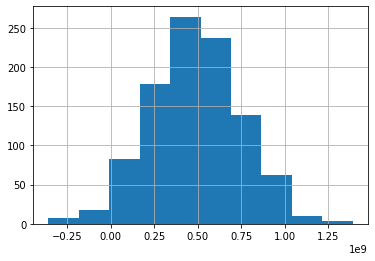

In [24]:
pd.Series(results_0).hist()

<AxesSubplot:>

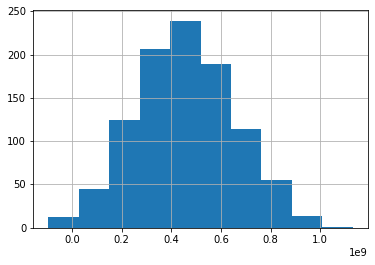

In [25]:
pd.Series(results_1).hist()

<AxesSubplot:>

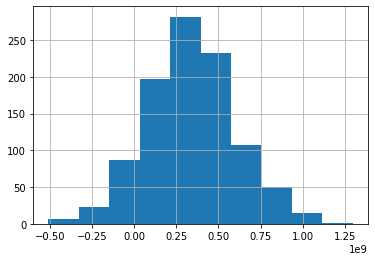

In [26]:
pd.Series(results_2).hist()

In [27]:
pd.Series(results_0).quantile([.025, .975])

0.025   -1.248195e+05
0.975    9.928629e+08
dtype: float64

In [28]:
pd.Series(results_1).quantile([.025, .975])

0.025    7.817677e+07
0.975    8.366680e+08
dtype: float64

In [29]:
pd.Series(results_2).quantile([.025, .975])

0.025   -1.595499e+08
0.975    8.784124e+08
dtype: float64

Наибольшая средняя прибыль зафиксирована в первом регионе. С другой стороны, в первом и третьем регионе довольно большая среднеквадратическая ошибка, которая не позволяет делает точный прогноз.

**Вывод:**
по итогам моделирования показателей прибыли только второй регион показал низкую вероятность убытков (менее 2,5%). В первом регионе показана наиболее высокая вероятная прибыль, но риск убытков равен 2,5%. Показатели средней прибыли второго региона всего на 6,1% ниже, чем в первом регионе, но риск убытков ниже почти в 2,5 раза. Поэтому **рекомендуется вести добычу во втором регионе**.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован